# Tutorial for vaex as a library
## Introduction
This tutorial shortly introduces how to use vaex from IPython notebook. This tutorial assumes you have vaex installed as a library, you can run `python -c 'import vaex'` to check this.
This document although not a IPython notebook, is generated from a notebook, and you should be able to reproduce all examples.

## Run IPython notebook
From the <a href='http://ipython.org/notebook.html'>IPython notebook website:</a>
> The IPython Notebook is an interactive computational environment, in which you can combine code execution, rich text, mathematics, plots and rich media

To start it, run `$ ipython notebook` in your shell, and it should automatically open the main webpage. Start a new notebook by clicking `new`.

## Starting
Start you notebook by importing the relevant packages, for this tutorial, we will be using vaex itself, <a href="www.nupmy.org">numpy</a> and <a href="matplotlib.org">matplotlib</a> for plotting. We also configure matplotib to show the plots in the notebook itself

In [50]:
import vaex as vx
import numpy as np
import pylab # simpler interface for matplotlib
# next line configures matplotlib to show the plots in the notebook, other option is qt to open a dialog
%matplotlib inline

## Open a dataset
To open a dataset, we can call vx.open to open local files. See the documentation of [vaex.open](vaex.html#vaex.open) for the arguments, hit shift-tab (1 or 2 times) or run `vx.open?` in the notebook for direct help. For this tutorial we use `vx.example()` which opens a dataset provided with vaex.

In [51]:
dataset = vx.example()
# dataset = vx.open('yourfile.hdf5') # in case you want to load a different dataset

You can get information about the dataset, such as the columns by simply typing `dataset` as the last command in a cell.

In [52]:
dataset

To get a list with all column names, use Dataset's [get_column_names](vaex.html#vaex.dataset.Dataset.get_column_names) method. Note that tab completion should work, typing `dataset.get_c` and then pressing tab should help your complete it.


In [53]:
dataset.get_column_names()

['x', 'y', 'z', 'vx', 'vy', 'vz', u'E', u'FeH', u'L', u'Lz', u'random_index']

## Using subspaces
Since we often work with a few columns, for instance 2 when we want to do plot, we create a [vaex.dataset.Subspace](vaex.html#vaex.dataset.Subspace)` from the dataset. We don't have to generate this object ourselves, we can call dataset.subspace(...) or simply dataset(..) for short.

In [54]:
subspace_xy = dataset("x", "y")
# Same as subspace_xy = dataset.subspace("x", "y")

Subspace contain methods to compute statistics, n dimensional histograms, and convenient plotting routines.
See the API documentation for more details:

* [Subspace.mean](vaex.html#vaex.dataset.Subspace.mean)
* [Subspace.var](vaex.html#vaex.dataset.Subspace.var)
* [Subspace.minmax](vaex.html#vaex.dataset.Subspace.minmax)
* [Subspace.histogram](vaex.html#vaex.dataset.Subspace.histogram)


In [55]:
print "means", subspace_xy.mean()
print "variance", subspace_xy.var()
xlimits, ylimits = subspace_xy.minmax()
print "(xmin, xmax) =", xlimits
print "(ymin, ymax) =", ylimits

means [-0.06713149 -0.05358987]
variance [ 53.54972406  60.62545068]
(xmin, xmax) = [-128.293991  271.365997]
(ymin, ymax) = [ -71.5523682  146.465836 ]


In [56]:
limits = subspace_xy.limits_sigma(square=True) # calculate the region around the mean with +/-3 sigma
# square=True forces the boundaries to be square by taking the means of the for sigma the mean sigma
grid = subspace_xy.histogram(limits)

Grid in this case is a two dimensional numpy array, which we will use for plotting. In this case it is 256x256, but you can pass an integer as argument to histogram to change the size (e.g. `subspace_xy.histogram(limits, size=128)`.

In [57]:
print "grid shape", grid.shape
print grid.sum(), "of a total of ", len(dataset), "objects are visible"

grid shape (256, 256)
321201.0 of a total of  330000 objects are visible


## Plotting
Now that we have 2d histogram, we can plot this using matplotlib, by using `pylab.imshow` (hint: use `pylab.imshow?` for help).

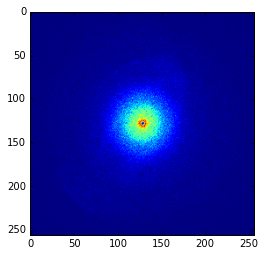

In [58]:
pylab.imshow(grid)

Matplotlib by default will show the image 'upside down', and it does not have information about the axis.

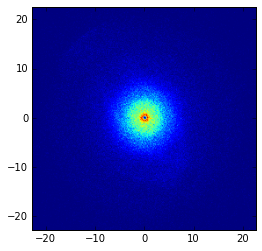

In [59]:
# limits is in the format [[xmin, xmax], [ymin, ymax]] while imshow wants it in
# [xmin, xmax, ymin, ymax], therefore we need to flatten the numpy array
pylab.imshow(grid, extent=limits.flatten(), origin='lower')

For convenience, wou can also use subspace_xy.plot(grid, limits) 

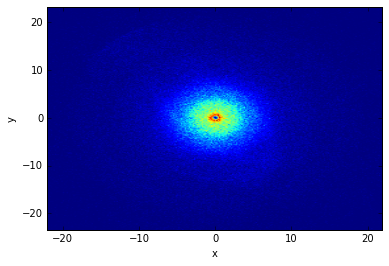

In [60]:
subspace_xy.plot(grid, limits)

A quicker way, but possibly less flexible is to use the Subspace.plot method without any arguments. By default it will calculated the limits of the subspace as above (by using limits_sigma) and will make a histogram of 256x256 and plot with the default colormap of matplotlib.

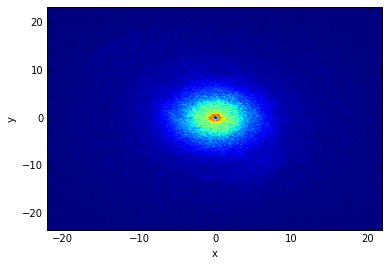

In [61]:
subspace_xy.plot()

Again, see the documentation of Subspace.plot by having the cursor near that method and hitting shift-tab (1 or 2 times) or see [Subspace.plot](vaex.html#vaex.dataset.Subspace.plot) for online documentation. You can also see the [prettified sourcecode](_modules/vaex/dataset.html#Subspace.plot) .
That should help you out finding out what the arguments are of plot.

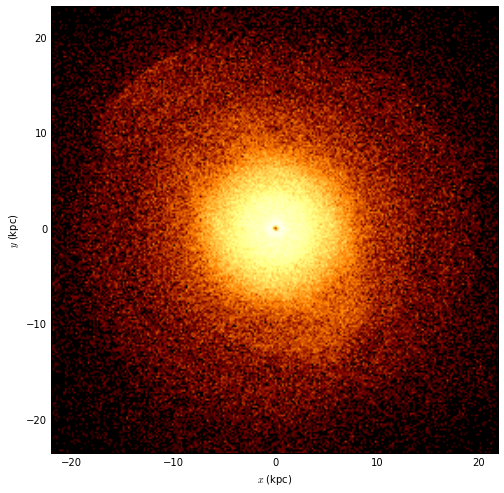

In [62]:
subspace_xy.plot(f=lambda x: np.log(1+x), figsize=(8,8), cmap="afmhot", xlabel="$x$ (kpc)", ylabel="$y$ (kpc)")

## Selections
For working with a part of the data, we introduce the concept of selections. When a selection is applied to a dataset, it keeps a boolean in memory for each row indicating it is selected or not. All operations applied to a (selected) subspace then will only use the rows that are selected.

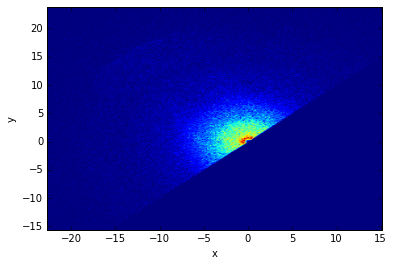

In [63]:
dataset.select("y > x")
# subspace_xy.selected() will return the same subspace, but will only use the selected rows
subspace_xy_selected = subspace_xy.selected()
subspace_xy_selected.plot()

Selection can be made more complicated, or can be logically combined using a boolean operator. The default is to replace the current selections, other possiblities are: "replace", "and", "or", "xor", "subtract"

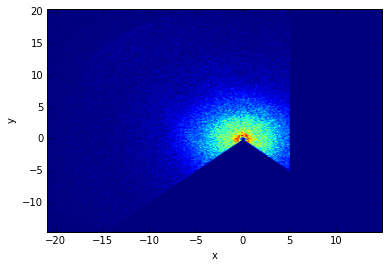

In [64]:
dataset.select("y > x")
dataset.select("y > -x", mode="or")
# this next line has the same effect as the above two
# dataset.select("(y > x) | (x > -y)")
# |,& and ^ are used for or and and xor
dataset.select("x > 5", mode="subtract")
subspace_xy_selected.plot()

Besides making plots, statisics can also be computed for selections

In [65]:
print subspace_xy_selected.minmax()
print subspace_xy_selected.mean()
print subspace_xy_selected.correlation()
print subspace_xy_selected.mutual_information()

[[-128.293991      4.99998713]
 [ -62.4985847   146.465836  ]]
[-2.98854513  2.99097581]
-0.0148138454008
0.211676605999


## Virtual columns
If a particular expression occurs often, it may be convenient to create a virtual column, it behaves exactly like a normal column, but it is calculated on the fly (without taking up the memory of a full column, since it is done is chunks).

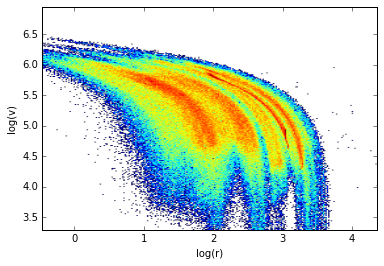

In [66]:
dataset.add_virtual_column("r", "sqrt(x**2+y**2+z**2)")
dataset.add_virtual_column("v", "sqrt(vx**2+vy**2+vz**2)")
rv = dataset("log(r)", "log(v)")
rv.plot(f=np.log)

## Dataset manipulations
Vaex works best with hdf5 and fits files, but can import from other sources as well. File formats are recognized by the extension. For .vot a VOTable is assumed, and astropy is used for reading this. For .asc the astropy's ascii reader is used. However, these formats require the dataset to fit into memory, and exporting them in hdf5 or fits format may lead to better performance and faster read times. Datasets can also be made from numpy arrays, in this example we create such a dataset, and export it to disk.

In [67]:
# Create a 6d gaussian clump
q = np.random.normal(10, 2, (6, 10000))
dataset_clump_arrays = vx.from_arrays(x=q[0], y=q[1], z=q[2], vx=q[3], vy=q[4], vz=q[5])
dataset_clump_arrays.add_virtual_column("r", "sqrt(x**2+y**2+z**2)")
dataset_clump_arrays.add_virtual_column("v", "sqrt(vx**2+vy**2+vz**2)")

# create a temporary file
import tempfile
filename = tempfile.mktemp(suffix=".hdf5")

# when exporting takes long, progress=True will give a progress bar
# here, we don't want to export virtual columns, which is the default
dataset_clump_arrays.export_hdf5(filename, progress=True, virtual=False)
print("Exported to: %s" % filename)

Exported to: /var/folders/vn/_rmzj8jd0215_g9yfrn8pmgm0000gn/T/tmpSO0peE.hdf5


exporting: 100% |####################################################################################################| Time: 0:00:00 CPU Usage:    33%



In [68]:
dataset_clump = vx.open(filename)
print("Columns: %r" % dataset_clump.get_column_names())

Columns: ['x', 'y', 'z', 'vx', 'vy', 'vz', u'r', u'v']


### concatenating tables
TODO

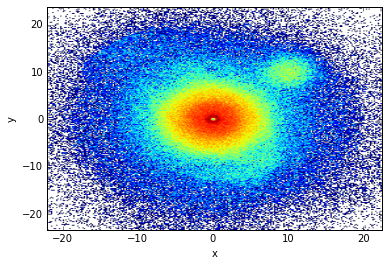

In [69]:
dataset_combined = dataset.concat(dataset_clump)
dataset_combined("x", "y").plot(f=np.log)

### Shuffling
TODO

## Statistics on multiple subspaces
If we want to calculate a correlation coefficient, we first need to calculate the mean, then the variance, and finally the covariance. Subspace.correlation will calculate the mean and variance for you if you don't provide them.

In [70]:
subspace_L_Lz = dataset("L", "Lz")
means = subspace_L_Lz.mean()
vars = subspace_L_Lz.var(means=means)
print "means", means
print subspace_L_Lz.correlation(means=means, vars=vars)
# this does the same but is much shorter
print subspace_L_Lz.correlation()

means [ 921.3784318   -19.03954714]
-0.128941177077
-0.128941177077


But if we now calculate the correlation coefficient of the E L subspace, we again let vaex calculate the mean and variance of L, which was already know.

In [71]:
subspace_E_L = dataset("E", "L")
print subspace_E_L.correlation()

0.689061916491


We can of course reuse the previous result, but stitching all this together is quite cumbersome, especially when large number of subspaces are used.
The Subspaces object will solve this for you, it keeps a list of Subspaces, and will only calculate statistics that are needed for multiple subspaces once.

In [72]:
# Dataset.subspaces can be called with a double list, where each element of the outer list defines a subspace 
subspaces = dataset.subspaces([["L", "Lz"], ["E", "L"]])
print "same as before", subspaces.correlation()

# the same holds as before, we can also calculate and reuse statistics 
means = subspaces.mean()
vars = subspaces.var(means=means)
print "same as before", subspaces.correlation(means=means, vars=vars)
# The same amount of calculations are done, we have a hold of the means and the variances


# To generate all subspace for a particular dimension, call it with the dimensions=D argument
all_subspaces_2d = dataset.subspaces(dimensions=2)
print "for all subspaces", all_subspaces_2d.correlation()



same as before [-0.12894117707684433, 0.6890619164905839]
same as before [-0.12894117707684433, 0.6890619164905839]
for all subspaces [-0.066913086088748977, -0.0265631290892482, -0.0077917898183533897, 0.00014018798239597753, 0.020449779578494913, -0.012435764665545164, 0.005261856198511411, -0.025662862458597193, -0.0003029405530995955, 0.0021574764913420436, 0.030838572698653258, 0.018049109980789083, -0.004114980900371849, -0.028477638600608889, -0.006099113309550405, 0.015003295277712896, -0.0083815889235114883, 0.02726004976035179, -0.0027409865565532297, -0.021753308878140792, 0.029883551266369459, -0.00965800489983153, 0.012445189872135566, -0.024137983404550291, 0.0032310346098219944, -0.063348964852397535, 0.028387450432461939, -0.035246043288534423, 0.0055509909480080779, -0.0062806723118258622, 0.010488839427889711, -0.0075209107558613496, 0.023592191806746595, -0.0052291556882942836, 0.009916570683825645, 0.017862999064108414, -0.011055183715438959, 0.023488436893898477, -

In [73]:
names = subspaces.names()
correlations = subspaces.correlation()
mutual_information = subspaces.mutual_information()


In [74]:
from astropy.io import ascii
import sys
ascii.write([names, correlations, mutual_information], sys.stdout, names=["names", "correlations", "mutual_information"])
# replace sys.stdout by a filename such as "example.asc"
filename_asc = tempfile.mktemp(suffix=".asc")
ascii.write([names, correlations, mutual_information], filename_asc, names=["names", "correlations", "mutual_information"])

print("--------")
# or write it as a latex table
ascii.write([names, correlations, mutual_information], sys.stdout, names=["names", "correlations", "mutual information"], Writer=ascii.Latex)


names correlations mutual_information
"L Lz" -0.12894117707684433 1.0372683973090797
"E L" 0.6890619164905839 0.7143281792612234
--------
\begin{table}
\begin{tabular}{ccc}
names & correlations & mutual information \\
L Lz & -0.128941177077 & 1.03726839731 \\
E L & 0.689061916491 & 0.714328179261 \\
\end{tabular}
\end{table}


In [75]:
# reading it back in
table = ascii.read(filename_asc)
print "this is an astropy table:\n", table
correlations = table["correlations"]
print
print "this is an astropy column:\n", correlations
print
print "this is the numpy data:\n", correlations.data
# short: table["correlation"].data

this is an astropy table:
names   correlations  mutual_information
----- --------------- ------------------
 L Lz -0.128941177077      1.03726839731
  E L  0.689061916491     0.714328179261

this is an astropy column:
  correlations 
---------------
-0.128941177077
 0.689061916491

this is the numpy data:
[-0.12894118  0.68906192]
